### Optimisation of positioning of the turbine
This notebook will look to optimise the positioning of the turbine to provide maximum power output allowing for variation in position (and eventually RPM, and other design parameters)

In [1]:
import scipy.optimize as opt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from breastshot_calcs import breastTurbine
from river_class import river_obj
from undershot_calcs import underTurbine
from pyswarms.single.global_best import GlobalBestPSO
from pyswarm import pso

# Full optimisation workbook

This optimisation workbook will attempt to provide a region of best performance in the multi-dimensional parameter space of the turbine design features and installation sensitivities.

'''
the breastshot turbine is optimised first:

the objective function is the power output of the turbine as given by the analysis function

the constraints are detailed for each variable in the dictionary above

this is a large non-linear optimisation problem and so Particle Swarm Optimisation is used

'''

b_river = river_obj(width=0.77, depth=0.3, velocity=1.5, head=1)

# use pyswarms to set up the optimisation problem

num_particles = 100
dims = 6
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# radius, width, num_blades, x_centre, y_centre, RPM
mins = [0.2, 0.5, 3, 0.2, -b_river.head, 0]
maxs = [2, 2, 30, 3, 2, 40]
bounds = (mins, maxs)

print(dims, bounds)

b_turbine = breastTurbine(b_river)

# define the objective function
def fun(x):
    particle_powers = []
    for particle in x:
        b_turbine = breastTurbine(b_river)
        b_turbine.radius = particle[0]
        b_turbine.width = particle[1]
        b_turbine.num_blades = int(np.round(particle[2],0))
        b_turbine.x_centre = particle[3]
        b_turbine.y_centre = particle[4]
        b_turbine.RPM = particle[5]
        particle_powers.append(b_turbine.analysis())
    return -np.array(particle_powers)



# define optimiser

optimiser = GlobalBestPSO(n_particles=num_particles, dimensions=dims, options=options, bounds=bounds)

# run optimisation
cost, pos = optimiser.optimize(fun, iters=50)

# pos, cost = pso(fun, mins, maxs, swarmsize=100, maxiter=100)



# show the results
print(cost, pos)

# create a new turbine object with the optimised parameters
b_turbine.radius = pos[0]
b_turbine.width = pos[1]
b_turbine.num_blades = int(np.round(pos[2]))
b_turbine.x_centre = pos[3]
b_turbine.y_centre = pos[4]
b_turbine.RPM = pos[5]

# run the analysis again
b_turbine.analysis()

print('num blades: ', np.round(b_turbine.t_num_blades, 0))

print('blade width: ', b_turbine.width)
print('blade radius: ', b_turbine.radius)
print('blade RPM: ', b_turbine.RPM)
print('blade x centre: ', b_turbine.x_centre)
print('blade y centre: ', b_turbine.y_centre)

print('optimal power [W]: ', b_turbine.avg_power/1000**2)



In [2]:
# now repeat the optimisation for a range of river velocities

# use pyswarms to set up the optimisation problem
b_river = river_obj(width=0.77, depth=0.3, velocity=1.5, head=1)

num_particles = 20
dims = 6
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# radius, width, num_blades, x_centre, y_centre, RPM
mins = [0.168, 0.5, 3, 0, -b_river.head, 0]
maxs = [1, 2, 10, 3, 2, 40]
bounds = (mins, maxs)

optimiser = GlobalBestPSO(n_particles=num_particles, dimensions=dims, options=options, bounds=bounds)

# define the range of velocities
velocities = np.linspace(0.5, 10, 10)

# create a dataframe to store the results
b_results = pd.DataFrame(columns=['flow rate', 'power', 'radius', 'width', 'num_blades', 'x_centre', 'y_centre', 'RPM'])

# loop through the velocities
for velocity in velocities:
    # create a new river object
    b_river = river_obj(width=0.77, depth=0.3, velocity=velocity, head=1)
    # create a new turbine object
    b_turbine = breastTurbine(b_river)

    # define the objective function
    def fun(x):
        particle_powers = []
        for particle in x:
            b_turbine = breastTurbine(b_river)
            b_turbine.radius = particle[0]
            b_turbine.width = particle[1]
            b_turbine.num_blades = int(np.round(particle[2],0))
            b_turbine.x_centre = particle[3]
            b_turbine.y_centre = particle[4]
            b_turbine.RPM = particle[5]
            particle_powers.append(b_turbine.analysis())
        return -np.array(particle_powers)

    # run the optimisation
    cost, pos = optimiser.optimize(fun, iters=50)
    # store the results
    b_results = b_results.append({'flow rate': b_river.vol_flow_rate, 'power': -cost, 'radius': pos[0], 'width': pos[1], 'num_blades': np.round(pos[2],0), 'x_centre': pos[3], 'y_centre': pos[4], 'RPM': pos[5]}, ignore_index=True)



2023-04-19 13:32:03,366 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/50/Users/philblecher/Desktop/Github/DP4-code/breastshot_calcs.py:146: RuntimeWarning: invalid value encountered in sqrt
  fall_v = np.sqrt(2 * self.g * (-self.y_centre + self.river.head  + self.river.nappe_height/2 - self.radius * np.cos(theta)))
/Users/philblecher/Desktop/Github/DP4-code/breastshot_calcs.py:250: RuntimeWarning: invalid value encountered in sqrt
  fall_river_flow = np.sqrt(2 * self.g * (self.river.head + self.river.nappe_height/2 - (self.y_centre  + self.radius * np.cos(theta)))) * self.width * self.radius * np.sin(theta - self.theta_entry)
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-1.43e+6
2023-04-19 13:32:38,997 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1433338.0440528784, best pos: [ 0.92414875  1.88779627  8.79924771  1.91633123  0.85283648 35.19

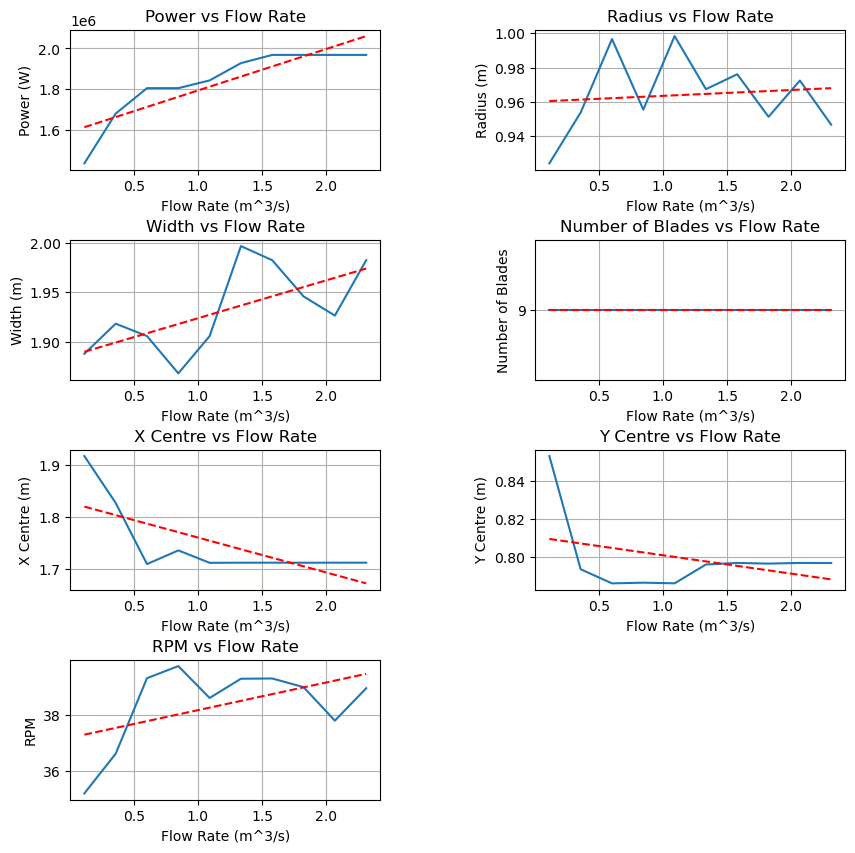

In [3]:
# plot the results of the optimisation

# make figure
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
# fig.suptitle('Breastshot Turbine Optimisation Results')

# add vertical space between the plots
fig.subplots_adjust(hspace=0.5)
# add horizontal space between the plots
fig.subplots_adjust(wspace=0.5)

# plot the power vs flow rate
axs[0, 0].plot(b_results['flow rate'], b_results['power'])
axs[0, 0].set_title('Power vs Flow Rate')
axs[0, 0].set_xlabel('Flow Rate (m^3/s)')
axs[0, 0].set_ylabel('Power (W)')
# add a trendline
z = np.polyfit(b_results['flow rate'], b_results['power'], 1)
p = np.poly1d(z)
axs[0, 0].plot(b_results['flow rate'], p(b_results['flow rate']), 'r--')

axs[0, 0].grid()

# plot the radius vs flow rate
axs[0, 1].plot(b_results['flow rate'], b_results['radius'])
axs[0, 1].set_title('Radius vs Flow Rate')
axs[0, 1].set_xlabel('Flow Rate (m^3/s)')
axs[0, 1].set_ylabel('Radius (m)')

# add a trendline
z = np.polyfit(b_results['flow rate'], b_results['radius'], 1)
p = np.poly1d(z)
axs[0, 1].plot(b_results['flow rate'], p(b_results['flow rate']), 'r--')

axs[0, 1].grid()

# plot the width vs flow rate
axs[1, 0].plot(b_results['flow rate'], b_results['width'])
axs[1, 0].set_title('Width vs Flow Rate')
axs[1, 0].set_xlabel('Flow Rate (m^3/s)')
axs[1, 0].set_ylabel('Width (m)')

# add a trendline
z = np.polyfit(b_results['flow rate'], b_results['width'], 1)
p = np.poly1d(z)
axs[1, 0].plot(b_results['flow rate'], p(b_results['flow rate']), 'r--')

axs[1, 0].grid()

# plot the number of blades vs flow rate
axs[1, 1].plot(b_results['flow rate'], b_results['num_blades'])
axs[1, 1].set_title('Number of Blades vs Flow Rate')
axs[1, 1].set_xlabel('Flow Rate (m^3/s)')
axs[1, 1].set_ylabel('Number of Blades')
# make sure the number of blades is an integer
axs[1, 1].set_yticks(np.arange(3, 11, 1))

# add a trendline
z = np.polyfit(b_results['flow rate'], b_results['num_blades'], 1)
p = np.poly1d(z)
axs[1, 1].plot(b_results['flow rate'], p(b_results['flow rate']), 'r--')

axs[1, 1].grid()

# plot the x centre vs flow rate
axs[2, 0].plot(b_results['flow rate'], b_results['x_centre'])
axs[2, 0].set_title('X Centre vs Flow Rate')
axs[2, 0].set_xlabel('Flow Rate (m^3/s)')
axs[2, 0].set_ylabel('X Centre (m)')

# add a trendline
z = np.polyfit(b_results['flow rate'], b_results['x_centre'], 1)
p = np.poly1d(z)
axs[2, 0].plot(b_results['flow rate'], p(b_results['flow rate']), 'r--')

axs[2, 0].grid()

# plot the y centre vs flow rate
axs[2, 1].plot(b_results['flow rate'], b_results['y_centre'])
axs[2, 1].set_title('Y Centre vs Flow Rate')
axs[2, 1].set_xlabel('Flow Rate (m^3/s)')
axs[2, 1].set_ylabel('Y Centre (m)')

# add a trendline
z = np.polyfit(b_results['flow rate'], b_results['y_centre'], 1)
p = np.poly1d(z)
axs[2, 1].plot(b_results['flow rate'], p(b_results['flow rate']), 'r--')

axs[2, 1].grid()

# plot the RPM vs flow rate
axs[3, 0].plot(b_results['flow rate'], b_results['RPM'])
axs[3, 0].set_title('RPM vs Flow Rate')
axs[3, 0].set_xlabel('Flow Rate (m^3/s)')
axs[3, 0].set_ylabel('RPM')

# add a trendline
z = np.polyfit(b_results['flow rate'], b_results['RPM'], 1)
p = np.poly1d(z)
axs[3, 0].plot(b_results['flow rate'], p(b_results['flow rate']), 'r--')

axs[3, 0].grid()

# remove the empty plot
fig.delaxes(axs[3, 1])



# show the figure
plt.show()





In [4]:
# do an optimisation for both types of turbine simultaneously

# create a dataframe to store the results - no position optimisation stored
results = pd.DataFrame(columns=['flow rate', 'power', 'radius', 'width', 'num_blades', 'RPM', 'type'])

# use pyswarms to set up the optimisation problem
river = river_obj(width=0.77, depth=0.3, velocity=1.5, head=1)

num_particles = 50
dims = 7
options = {'c1': 0.6, 'c2': 0.3, 'w':0.9}

# radius, width, num_blades, bx_centre, by_centre, uy_centre, RPM
mins = [0.168, 0.5, 3, 0, -river.head, 0, 0]
maxs = [1, 2, 10, 5, 5, 5, 40]
bounds = (mins, maxs)

# create the optimisation problem
optimiser = GlobalBestPSO(n_particles=num_particles, dimensions=dims, options=options, bounds=bounds)

# define the range of velocities
velocities = np.linspace(0.5, 10, 20)

# loop through the velocities
for velocity in velocities:
    # create a new river object
    river = river_obj(width=0.77, depth=0.3, velocity=velocity, head=1)
    # create a new turbine object
    b_turbine = breastTurbine(river, x_centre=1, y_centre=0)
    u_turbine = underTurbine(river, y_centre=0.1)

    # define the base cases
    base_breast_power = b_turbine.analysis()
    base_under_power = u_turbine.analysis()


    # define the objective function
    def fun(x):
        particle_powers = []
        for particle in x:
            b_turbine = breastTurbine(river)
            b_turbine.radius = particle[0]
            b_turbine.width = particle[1]
            b_turbine.num_blades = int(np.round(particle[2],0))
            b_turbine.x_centre = particle[3]
            b_turbine.y_centre = particle[4]
            b_turbine.RPM = particle[6]

            u_turbine = underTurbine(river)
            u_turbine.radius = particle[0]
            u_turbine.width = particle[1]
            u_turbine.num_blades = int(np.round(particle[2],0))
            u_turbine.y_centre = particle[5]
            u_turbine.RPM = particle[6]

            b_power = (b_turbine.analysis() - base_breast_power) / base_breast_power
            u_power = (u_turbine.analysis() - base_under_power) / base_under_power

            # add the power to the list but ensure that the weightings for each turbine are of equal importance
            particle_powers.append((b_power + u_power) / 2)

        return -np.array(particle_powers)

    # run the optimisation
    cost, pos = optimiser.optimize(fun, iters=50)
    # store the results
    results = results.append({'flow rate': river.vol_flow_rate, 'average power': -cost, 'radius': pos[0], 'width': pos[1], 'num_blades': np.round(pos[2],0),  'RPM': pos[6]}, ignore_index=True)



2023-04-19 13:36:40,385 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/50/Users/philblecher/Desktop/Github/DP4-code/breastshot_calcs.py:146: RuntimeWarning: invalid value encountered in sqrt
  fall_v = np.sqrt(2 * self.g * (-self.y_centre + self.river.head  + self.river.nappe_height/2 - self.radius * np.cos(theta)))
/Users/philblecher/Desktop/Github/DP4-code/breastshot_calcs.py:250: RuntimeWarning: invalid value encountered in sqrt
  fall_river_flow = np.sqrt(2 * self.g * (self.river.head + self.river.nappe_height/2 - (self.y_centre  + self.radius * np.cos(theta)))) * self.width * self.radius * np.sin(theta - self.theta_entry)
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-4.14e+3
2023-04-19 13:37:43,646 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -4144.2934789794035, best pos: [ 0.98969934  1.83596734  9.62580559  2.97668058  0.72456483  1.14

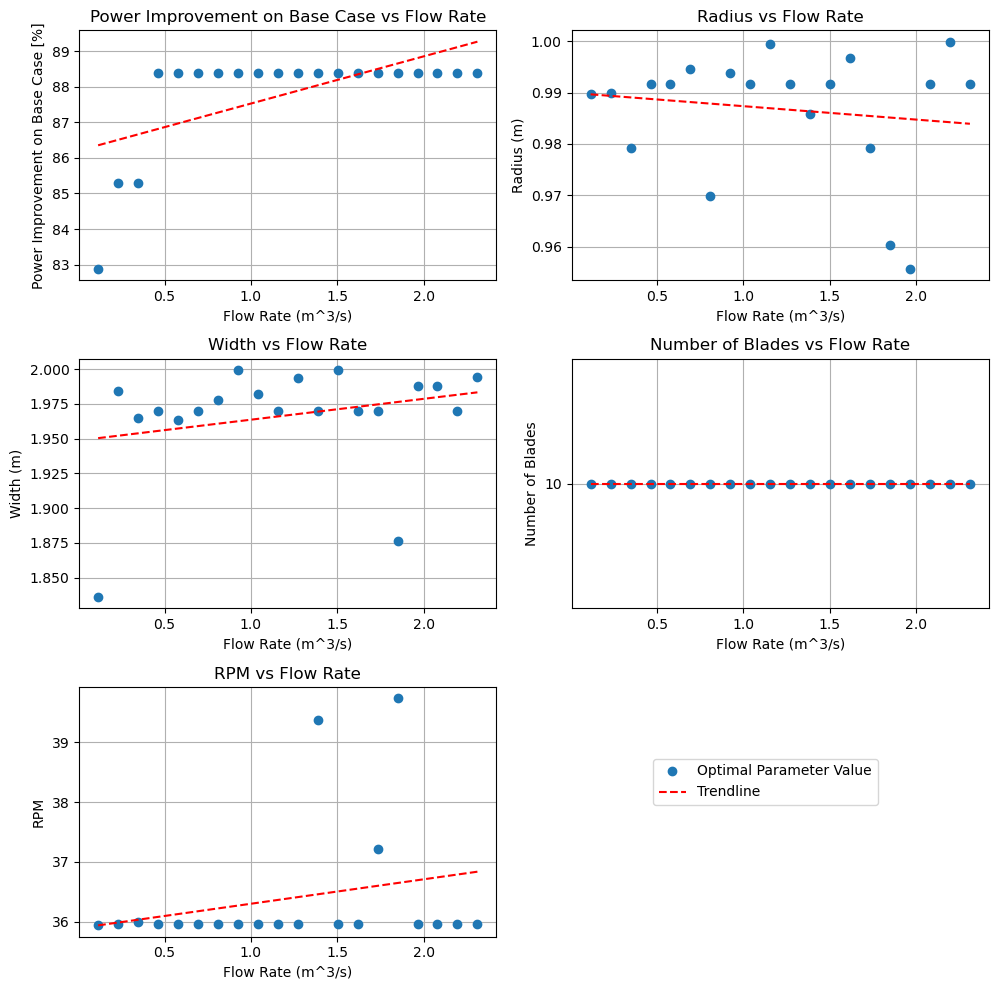

In [6]:
# plot the results of the optimisation

# make figure
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
# fig.suptitle('Breastshot Turbine Optimisation Results')

# add vertical space between the plots
fig.subplots_adjust(hspace=0.5)
# add horizontal space between the plots
fig.subplots_adjust(wspace=0.5)

# plot the power vs flow rate
axs[0, 0].plot(results['flow rate'], results['average power']/50, 'o')
axs[0, 0].set_title('Power Improvement on Base Case vs Flow Rate')
axs[0, 0].set_xlabel('Flow Rate (m^3/s)')
axs[0, 0].set_ylabel('Power Improvement on Base Case [%]')
# add a trendline
z = np.polyfit(results['flow rate'], results['average power']/50, 1)
p = np.poly1d(z)
axs[0, 0].plot(results['flow rate'], p(results['flow rate']), 'r--')

axs[0, 0].grid()

# plot the radius vs flow rate
axs[0, 1].plot(results['flow rate'], results['radius'], 'o')
axs[0, 1].set_title('Radius vs Flow Rate')
axs[0, 1].set_xlabel('Flow Rate (m^3/s)')
axs[0, 1].set_ylabel('Radius (m)')

# add a trendline
z = np.polyfit(results['flow rate'], results['radius'], 1)
p = np.poly1d(z)
axs[0, 1].plot(results['flow rate'], p(results['flow rate']), 'r--')

axs[0, 1].grid()

# plot the width vs flow rate
axs[1, 0].plot(results['flow rate'], results['width'], 'o')
axs[1, 0].set_title('Width vs Flow Rate')
axs[1, 0].set_xlabel('Flow Rate (m^3/s)')
axs[1, 0].set_ylabel('Width (m)')

# add a trendline
z = np.polyfit(results['flow rate'], results['width'], 1)
p = np.poly1d(z)
axs[1, 0].plot(results['flow rate'], p(results['flow rate']), 'r--')

axs[1, 0].grid()

# plot the number of blades vs flow rate
axs[1, 1].plot(results['flow rate'], results['num_blades'], 'o')
axs[1, 1].set_title('Number of Blades vs Flow Rate')
axs[1, 1].set_xlabel('Flow Rate (m^3/s)')
axs[1, 1].set_ylabel('Number of Blades')
# make sure the number of blades is an integer
axs[1, 1].set_yticks(np.arange(3, 11, 1))

# add a trendline
z = np.polyfit(results['flow rate'], results['num_blades'], 1)
p = np.poly1d(z)
axs[1, 1].plot(results['flow rate'], p(results['flow rate']), 'r--')

axs[1, 1].grid()


# plot the RPM vs flow rate
axs[2, 0].plot(results['flow rate'], results['RPM'], 'o')
axs[2, 0].set_title('RPM vs Flow Rate')
axs[2, 0].set_xlabel('Flow Rate (m^3/s)')
axs[2, 0].set_ylabel('RPM')

# add a trendline
z = np.polyfit(results['flow rate'], results['RPM'], 1)
p = np.poly1d(z)
axs[2, 0].plot(results['flow rate'], p(results['flow rate']), 'r--')

axs[2, 0].grid()

# put a legend in the space of the final plot
axs[2, 1].axis('off')
fig.legend(['Optimal Parameter Value','Trendline'], loc='lower right', ncol=1, bbox_to_anchor=(0.75, 0.5), bbox_transform=axs[2, 1].transAxes)
# make the legend fill the whole plot




fig.tight_layout()
# show the figure
plt.show()
